In [119]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [324]:
# OLD
etas = [0.1]
batches = [256]
epochs = [20]
rhos = np.linspace(0., 1, 7)
mus = np.linspace(0., 1, 7)
repetitions = 7

In [325]:
print(rhos, mus)

[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ] [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]


In [95]:
# new (fine-grained)
etas = [0.1]
batches = [256]
epochs = [20]
rhos = np.linspace(0.6, 0.8, 5)
mus = np.linspace(0.4, 0.6, 5)

In [326]:
rhos

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        ])

In [327]:
def print_nice(y):
    if isinstance(y, float):
        return '%.2f' % y
    return str(y)

In [328]:
def print_one(**kwargs):
    print('python experiment.py ' + " ".join(['--' + x + ' ' + print_nice(y) for x, y in kwargs.items()]) + ' &')

In [329]:
def get_file(**kwargs):
    return ("_".join([x + '-' + print_nice(y) for x, y in kwargs.items()])+'.output')

In [330]:
print(get_file(aba = 'caba', dd = 'dd'))
print_one(aba = 'caba', dd = 'dd')

aba-caba_dd-dd.output
python experiment.py --aba caba --dd dd &


In [332]:
it = 0
for rounds in range(repetitions):
    for eta in etas:
        for b in batches:
            for e in epochs:
                for rho in rhos:
                    mu = 0
                    print_one(iteration = rounds, eta = eta, rho = rho, mu = mu, epochs = e, train_batch_size = b)
                    it += 1
                for mu in mus:
                    rho = 0
                    print_one(iteration = rounds, eta = eta, rho = rho, mu = mu, epochs = e, train_batch_size = b)
                    it += 1
print('Total runs: ', it)
print('Total time: ', it / 6)

python experiment.py --iteration 0 --eta 0.10 --rho 0.00 --mu 0 --epochs 20 --train_batch_size 256 &
python experiment.py --iteration 0 --eta 0.10 --rho 0.17 --mu 0 --epochs 20 --train_batch_size 256 &
python experiment.py --iteration 0 --eta 0.10 --rho 0.33 --mu 0 --epochs 20 --train_batch_size 256 &
python experiment.py --iteration 0 --eta 0.10 --rho 0.50 --mu 0 --epochs 20 --train_batch_size 256 &
python experiment.py --iteration 0 --eta 0.10 --rho 0.67 --mu 0 --epochs 20 --train_batch_size 256 &
python experiment.py --iteration 0 --eta 0.10 --rho 0.83 --mu 0 --epochs 20 --train_batch_size 256 &
python experiment.py --iteration 0 --eta 0.10 --rho 1.00 --mu 0 --epochs 20 --train_batch_size 256 &
python experiment.py --iteration 0 --eta 0.10 --rho 0 --mu 0.00 --epochs 20 --train_batch_size 256 &
python experiment.py --iteration 0 --eta 0.10 --rho 0 --mu 0.17 --epochs 20 --train_batch_size 256 &
python experiment.py --iteration 0 --eta 0.10 --rho 0 --mu 0.33 --epochs 20 --train_batch_s

In [261]:
def process_dict(d, do_plot = False):
    if do_plot:
        plt.title('Train loss')
        plt.plot(d['train_batch_losses'])
        plt.show()
        plt.title('Train accuracy')
        plt.plot(d['train_batch_accs'])
        plt.show()
    del d['train_batch_losses'], d['train_batch_accs']
    return d

In [262]:
def process_file(f):
    f = open(f, 'r').read()
    d = eval(f)
    return process_dict(d)

In [263]:
def process_files(params, param_name, files):
    """ files -- list of lists """
    
    # files
    # list of lists of files
    # [param_id][round]
    
    # dictionary key (accuracy) -> [param_id][round]
    quantities = {}
    for param_id, param_sets in enumerate(files):
        for round_id, f in enumerate(param_sets):
            try:
                d = process_file(f)
            except:
                print(f + " NO FILE")
                continue
            #print(d)
            for x, y in d.items():
            #print(y)
            # add quantities[x][param_id][round_id] = y
                if x not in quantities:
                    quantities[x] = [[]] * len(files)
                #print(quantities[x], param_id)
                #print(param_id)
                if param_id == 0 and x == 'train_accuracy':
                    print(param_id, round_id, x, y)
                    quantities[x][param_id].append(y)
            
            
    #print(len(quantities['train_accuracy']), len(quantities['train_accuracy'][0]))
    
    #print(quantities['train_accuracy'][0])
    
    return
    
    for x, y in quantities.items():
        print(x + ": min/max " + str(np.min(y)) + "/" + str(np.max(y)))
            
    plt.figure()
    plt.title('Accuracy over ' + param_name)
    plt.plot(params, quantities['test_accuracy'], label = 'Test accuracy')
    plt.plot(params, quantities['train_accuracy'], label = 'Test accuracy')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.title('Loss over ' + param_name)
    plt.plot(params, quantities['test_loss'], label = 'Test loss')
    plt.plot(params, quantities['train_loss'], label = 'Test loss')
    plt.legend()
    plt.show()

In [269]:
def process_files(params, name, fs):
    """
    Input: params: array of len N with parameter values
    name: Name of the parameter
    fs: 2D array N x R where R = repetitions
    """
    
    # dictionary quantity -> 2D array N x R
    results = {}
    
    for param_id, rounds in enumerate(fs):
        #print(param_id, rounds)
        for round_id, f in enumerate(rounds):
            try:
                d = process_file(f)
            except:
                print(f)
                continue
            for x, y in d.items():
                if x not in results:
                    results[x] = np.zeros((len(fs), len(rounds)))
                #print('APPEND', x, param_id, y)
                results[x][param_id][round_id] = y
                    
    for metric, values in results.items():
        plt.figure()
        plt.title(metric + '/' + name)
        means = np.mean(values, axis = 1)
        print('Highest mean', np.max(means), params[np.argmax(means)])
        stds = np.std(values, axis = 1)
        plt.plot(params, means)
        plt.fill_between(params, means - stds, means + stds, alpha = 0.5)
        plt.show()

Highest mean 92.5593971674493 1.0


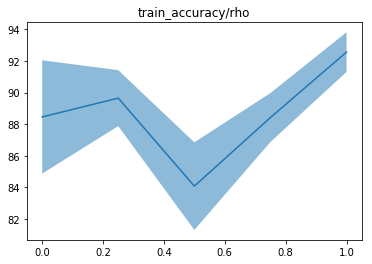

Highest mean 0.25483127396157446 0.5


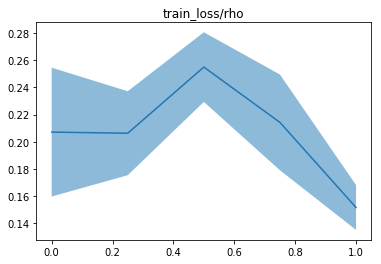

Highest mean 92.79999694824218 1.0


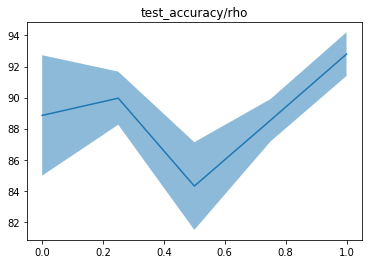

Highest mean 0.2532296240329742 0.5


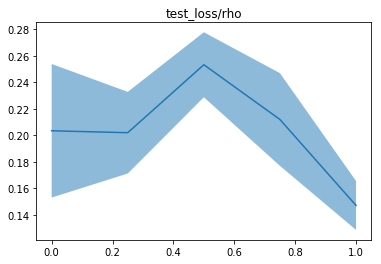

In [270]:
for eta in etas:
    for b in batches:
        for e in epochs:
            fs = [[get_file(eta = eta, rho = rho, mu = 0.0, epochs = e,
                           train_batch_size = b, iteration = rounds)
                   for rounds in range(5)] for rho in rhos]
            #print(fs[0])
            process_files(rhos, 'rho', fs)

Highest mean 93.04875887607007 0.5


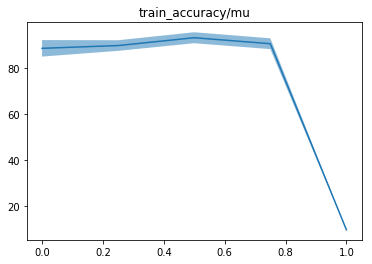

Highest mean 1.1021625213420139 1.0


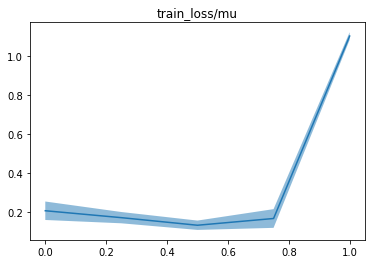

Highest mean 93.247998046875 0.5


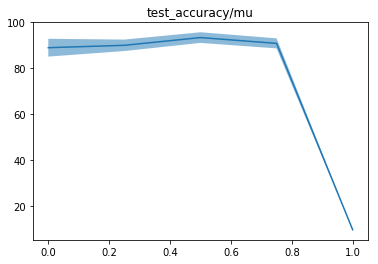

Highest mean 1.1020482301712036 1.0


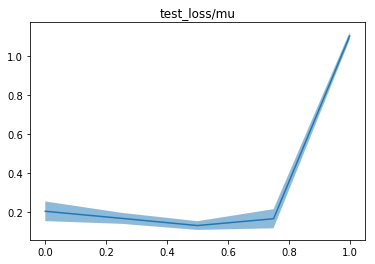

In [271]:
for eta in etas:
    for b in batches:
        for e in epochs:
            fs = [[get_file(eta = eta, rho = 0.0, mu = mu, epochs = e,
                           train_batch_size = b, iteration = rounds)
                   for rounds in range(5)] for mu in mus]
            #print(fs[0])
            process_files(rhos, 'mu', fs)